In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# %qtconsole
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

The goal of this notebook is to simulate the type of spike-spike coherence we might see during ripple times. Typically a burst of activity in CA1 and then a burst of activity in mPFC.

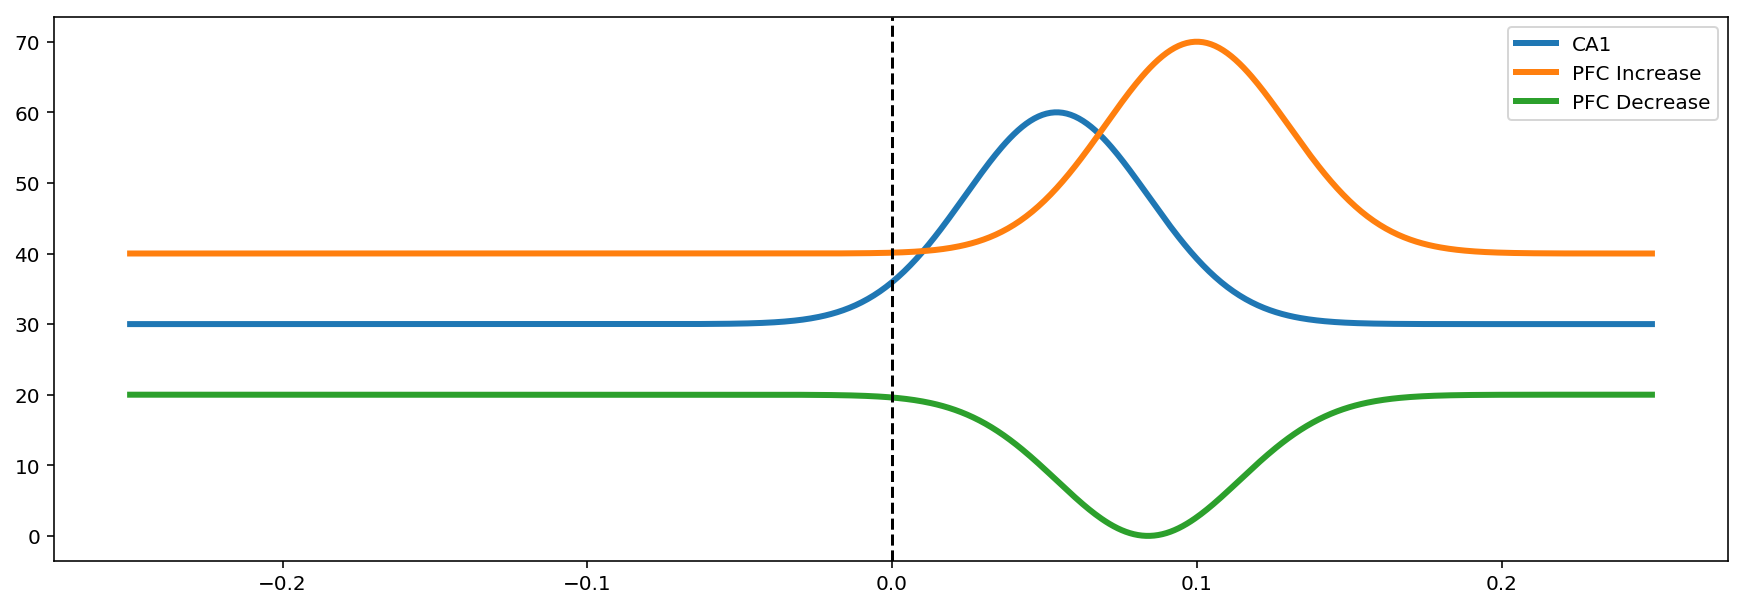

In [3]:
from scipy.stats import norm

sampling_frequency = 1500
total_time = 0.5 # second
n_samples = sampling_frequency * total_time

time = np.arange(n_samples) / sampling_frequency - total_time / 2

ca1_rate = norm(loc=0.054, scale=0.030).pdf(time)
ca1_rate = ca1_rate / ca1_rate.max() * 30
ca1_rate += 30

pfc_increase_rate = norm(loc=0.100, scale=0.030).pdf(time)
pfc_increase_rate = pfc_increase_rate / pfc_increase_rate.max() * 30
pfc_increase_rate += 40

pfc_decrease_rate = norm(loc=0.084, scale=0.030).pdf(time)
pfc_decrease_rate = pfc_decrease_rate / pfc_decrease_rate.max()
pfc_decrease_rate = (1 - pfc_decrease_rate) * 20


fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(time, ca1_rate, label='CA1', linewidth=3)
ax.plot(time, pfc_increase_rate, label='PFC Increase', linewidth=3)
ax.plot(time, pfc_decrease_rate, label='PFC Decrease', linewidth=3)
ax.axvline(0, color='black', linestyle='--')
ax.legend();

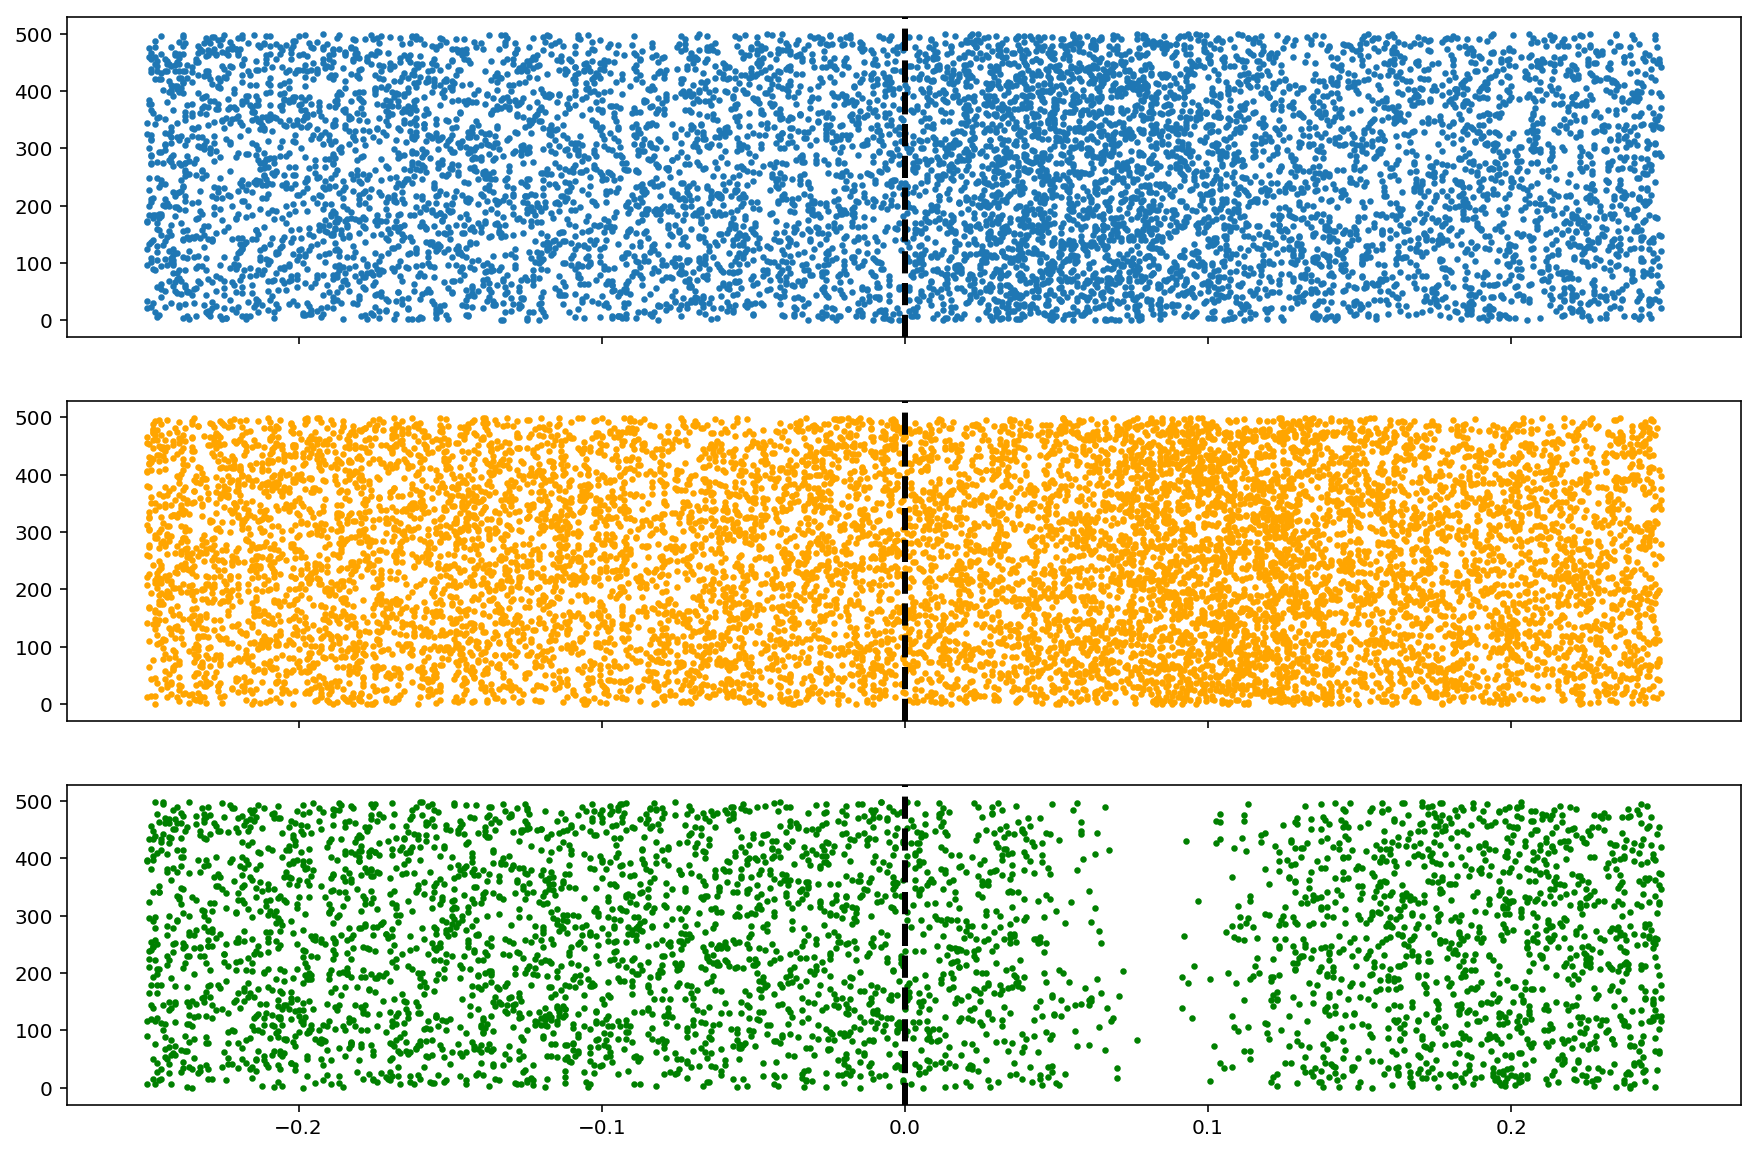

In [4]:
def get_spikes(rate, sampling_frequency=1500, n_trials=500):
    return np.random.poisson(
        rate[:, np.newaxis] * np.ones((n_trials,)) / sampling_frequency)

ca1_spikes = get_spikes(ca1_rate)
pfc_increase_spikes = get_spikes(pfc_increase_rate)
pfc_decrease_spikes = get_spikes(pfc_decrease_rate)

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True, sharey=True)

spike_times_ind, trial_ind = np.nonzero(ca1_spikes)
axes[0].scatter(time[spike_times_ind], trial_ind, s=5)
axes[0].axvline(0, color='black', linestyle='--', linewidth=3)

spike_times_ind, trial_ind = np.nonzero(pfc_increase_spikes)
axes[1].scatter(time[spike_times_ind], trial_ind, s=5, color='orange')
axes[1].axvline(0, color='black', linestyle='--', linewidth=3)

spike_times_ind, trial_ind = np.nonzero(pfc_decrease_spikes)
axes[2].scatter(time[spike_times_ind], trial_ind, s=5, color='green')
axes[2].axvline(0, color='black', linestyle='--', linewidth=3);

In [5]:
spikes = np.stack((ca1_spikes, pfc_increase_spikes, pfc_decrease_spikes), axis=-1)
spikes.shape

(750, 500, 3)

In [6]:
from spectral_connectivity import Multitaper, Connectivity

m = Multitaper(spikes, sampling_frequency, time_window_duration=total_time / 2, time_halfbandwidth_product=1)
c = Connectivity.from_multitaper(m)

print(m.frequency_resolution)

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.25, time_window_step=0.25,
           detrend_type='constant', start_time=0, n_tapers=1)


4.0


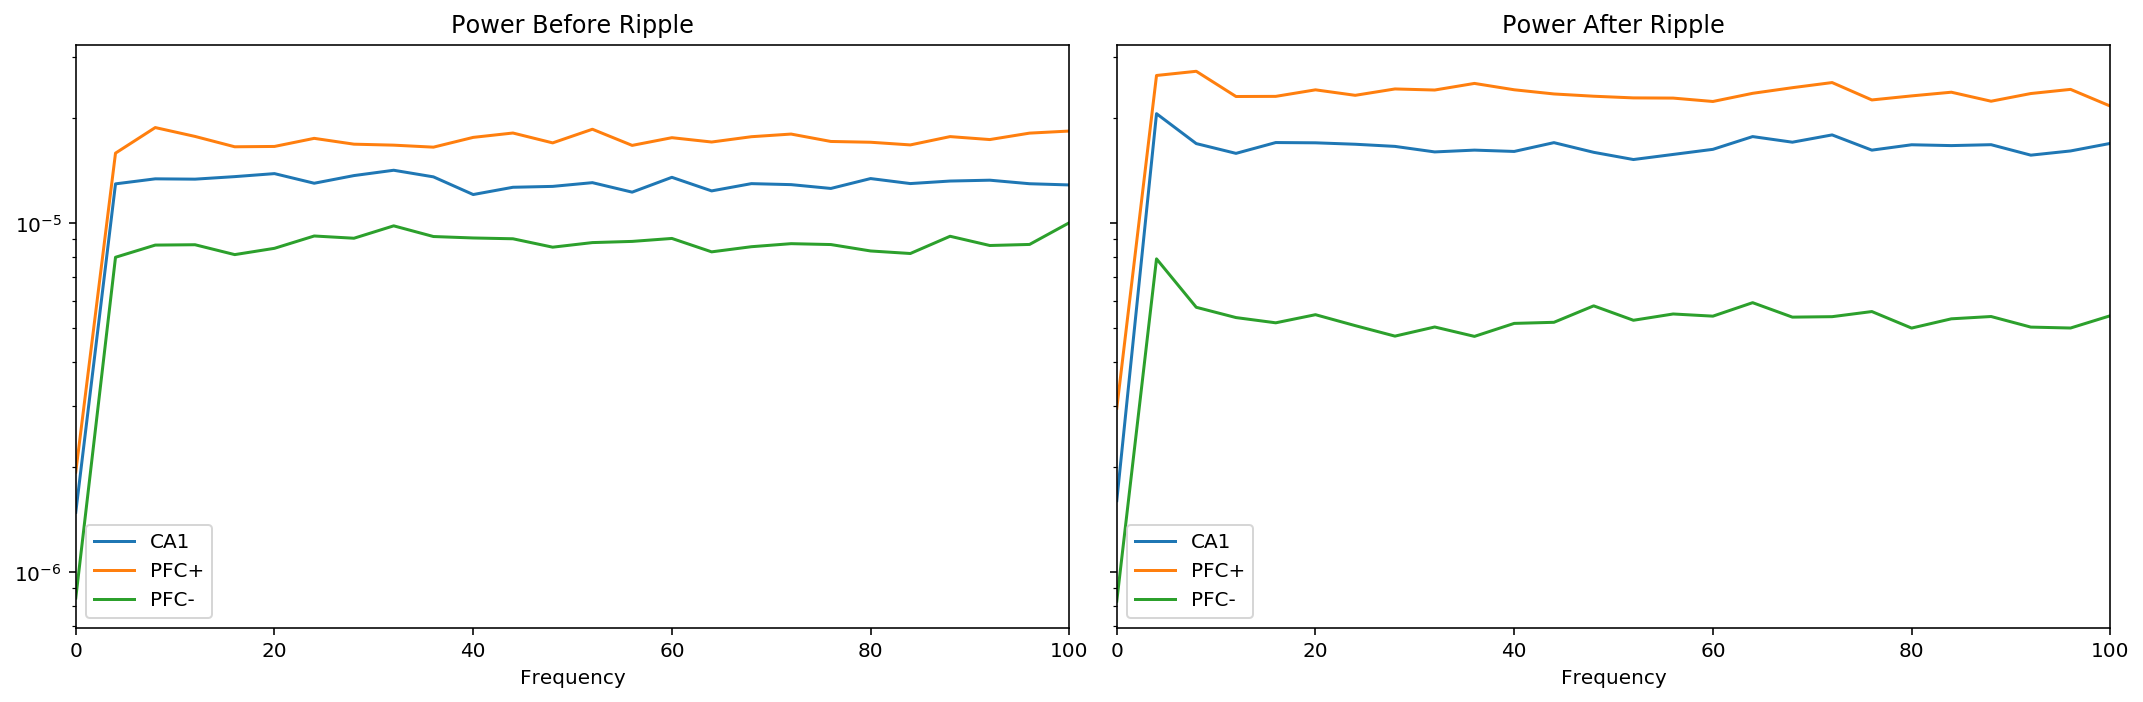

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
h = axes[0].semilogy(c.frequencies, c.power()[0, ...])
axes[0].legend(h, ['CA1', 'PFC+', 'PFC-'])
axes[0].set_title('Power Before Ripple')
axes[0].set_xlabel('Frequency')
axes[1].set_xlabel('Power')

h = axes[1].semilogy(c.frequencies, c.power()[1, ...])
axes[1].legend(h, ['CA1', 'PFC+', 'PFC-'])
axes[1].set_title('Power After Ripple');
axes[1].set_xlabel('Frequency')

plt.xlim((0, 100))
plt.tight_layout()

Unadjusted

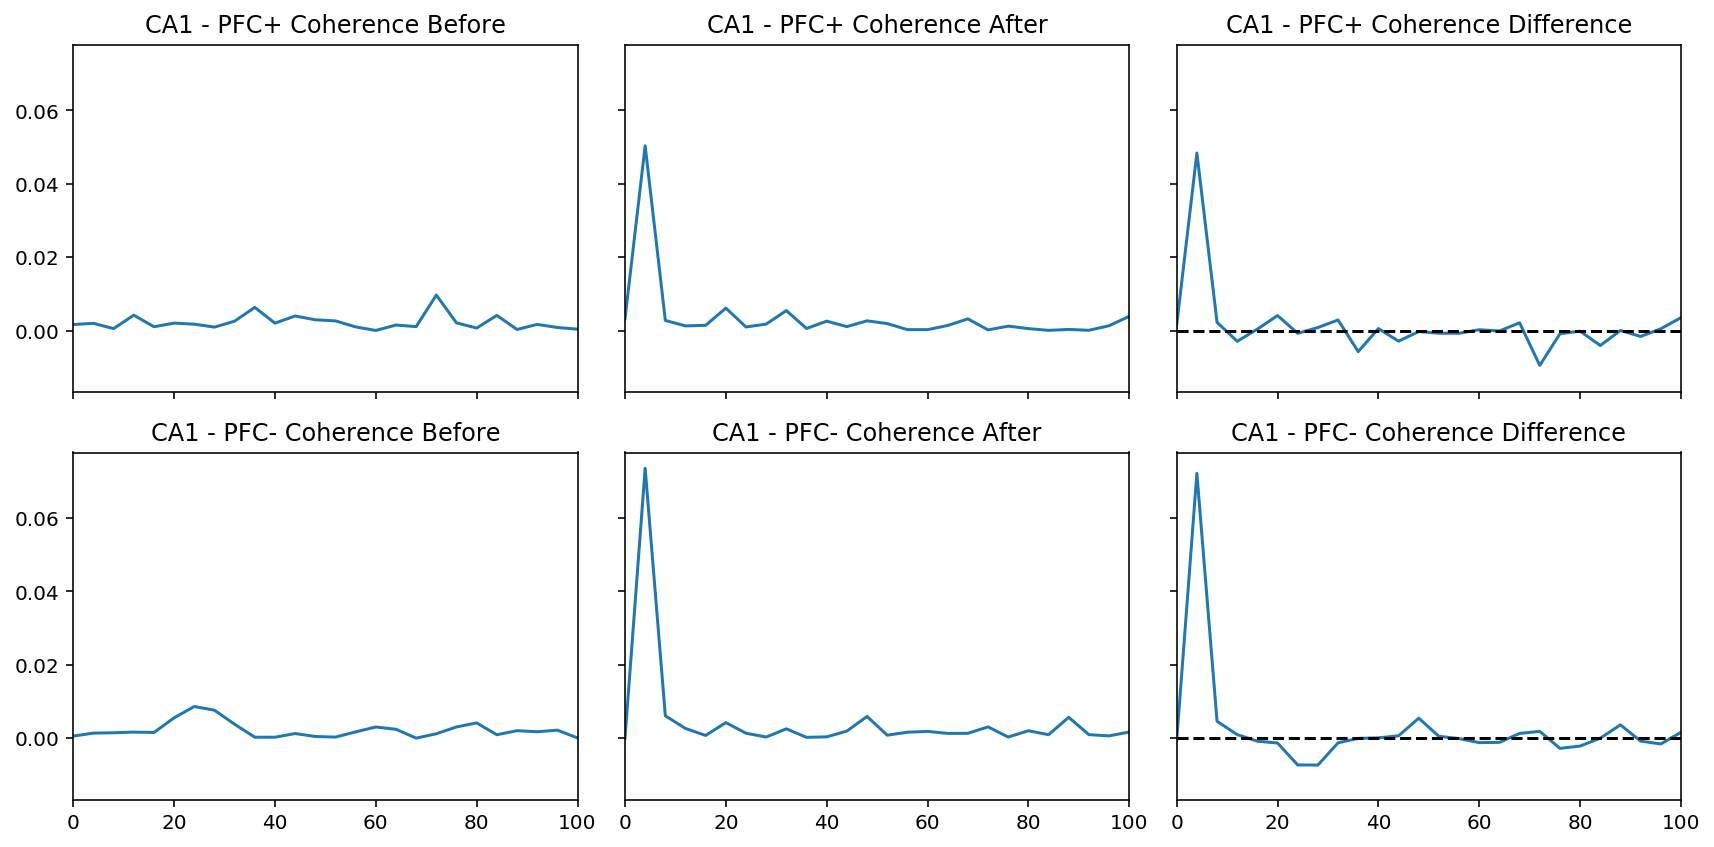

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

coherence_magnitude = c.coherence_magnitude()
coherence_change = np.diff(coherence_magnitude, axis=0)

# Before
axes[0, 0].plot(c.frequencies, coherence_magnitude[0, :, 0, 1])
axes[0, 0].set_title('CA1 - PFC+ Coherence Before')
axes[1, 0].plot(c.frequencies, coherence_magnitude[0, :, 0, 2])
axes[1, 0].set_title('CA1 - PFC- Coherence Before')

# After
axes[0, 1].plot(c.frequencies, coherence_magnitude[1, :, 0, 1])
axes[0, 1].set_title('CA1 - PFC+ Coherence After')
axes[1, 1].plot(c.frequencies, coherence_magnitude[1, :, 0, 2])
axes[1, 1].set_title('CA1 - PFC- Coherence After')

# Difference
axes[0, 2].plot(c.frequencies, coherence_change[0, :, 0, 1])
axes[0, 2].set_title('CA1 - PFC+ Coherence Difference')
axes[0, 2].axhline(0, color='black', linestyle='--')
axes[1, 2].plot(c.frequencies, coherence_change[0, :, 0, 2])
axes[1, 2].set_title('CA1 - PFC- Coherence Difference')
axes[1, 2].axhline(0, color='black', linestyle='--')

plt.xlim((0, 100))
plt.tight_layout()

Adjusted

In [9]:
def coherence_rate_adjustment(firing_rate_condition1,
                              firing_rate_condition2, spike_power_spectrum,
                              homogeneous_poisson_noise=0, dt=1):
    '''Correction for the spike-field or spike-spike coherence when the
    conditions have different firing rates.

    When comparing the coherence of two conditions, a change in firing rate
    results in a change in coherence without an increase in coupling.
    This adjustment modifies the coherence of one of the conditions, so
    that a difference in coherence between conditions indicates a change
    in coupling, not firing rate. See [1] for details.

    If using to compare spike-spike coherence, not that the coherence
    adjustment must be applied twice, once for each spike train.
    Adjusts `firing_rate_condition1` to `firing_rate_condition2`.
    
    Parameters
    ----------
    firing_rate_condition1, firing_rate_condition2 : float
        Average firing rates for each condition.
    spike_power_spectrum : ndarray, shape (n_frequencies,)
        Power spectrum of the spike train in condition 1.
    homogeneous_poisson_noise : float, optional
        Beta in [1].
    dt : float, optional
        Size of time step.
        
    Returns
    -------
    rate_adjustment_factor : ndarray, shape (n_frequencies,)
    
    References
    ----------
    .. [1] Aoi, M.C., Lepage, K.Q., Kramer, M.A., and Eden, U.T. (2015).
           Rate-adjusted spike-LFP coherence comparisons from spike-train
           statistics. Journal of Neuroscience Methods 240, 141-153.

    '''
    # alpha in [1]
    firing_rate_ratio = firing_rate_condition2 / firing_rate_condition1
    adjusted_firing_rate = (
        (1 / firing_rate_ratio - 1) * firing_rate_condition1 +
        homogeneous_poisson_noise / firing_rate_ratio ** 2) * dt ** 2
    return 1 / np.sqrt(1 + (adjusted_firing_rate / spike_power_spectrum))

In [17]:
from spectral_connectivity.transforms import _sliding_window

def adjusted_coherence_magnitude(spikes, sampling_frequency, **multitaper_params):
    '''
    
    Parameters
    ----------
    spikes : ndarray, shape (n_time, n_trials, n_signals)
    sampling_frequency : float
    **multitaper_params : kwargs
    
    Returns
    -------
    adjusted_coherence_magnitude : ndarray, shape (n_time, n_frequencies, n_signals, n_signals)

    '''
    m = Multitaper(spikes, sampling_frequency, **multitaper_params)
    c = Connectivity.from_multitaper(m)

    dt = 1.0 / sampling_frequency
    
    average_rate = _sliding_window(
        spikes, m.n_time_samples_per_window,
        m.n_time_samples_per_step, axis=0).mean(axis=(1,3)) # Multiply by 
    
    power = c.power()
    n_time_windows = average_rate.shape[0]
    
    adjustment_factor = np.stack([
        coherence_rate_adjustment(average_rate[0], average_rate[time_ind],
                                  power[0, ...], dt=dt)
        for time_ind in range(n_time_windows)
    ], axis=0)[..., np.newaxis]
    
    return np.abs(c.coherency()
                  * adjustment_factor *
                  adjustment_factor.swapaxes(-1, -2))
        
    

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.25, time_window_step=0.25,
           detrend_type='constant', start_time=0, n_tapers=1)


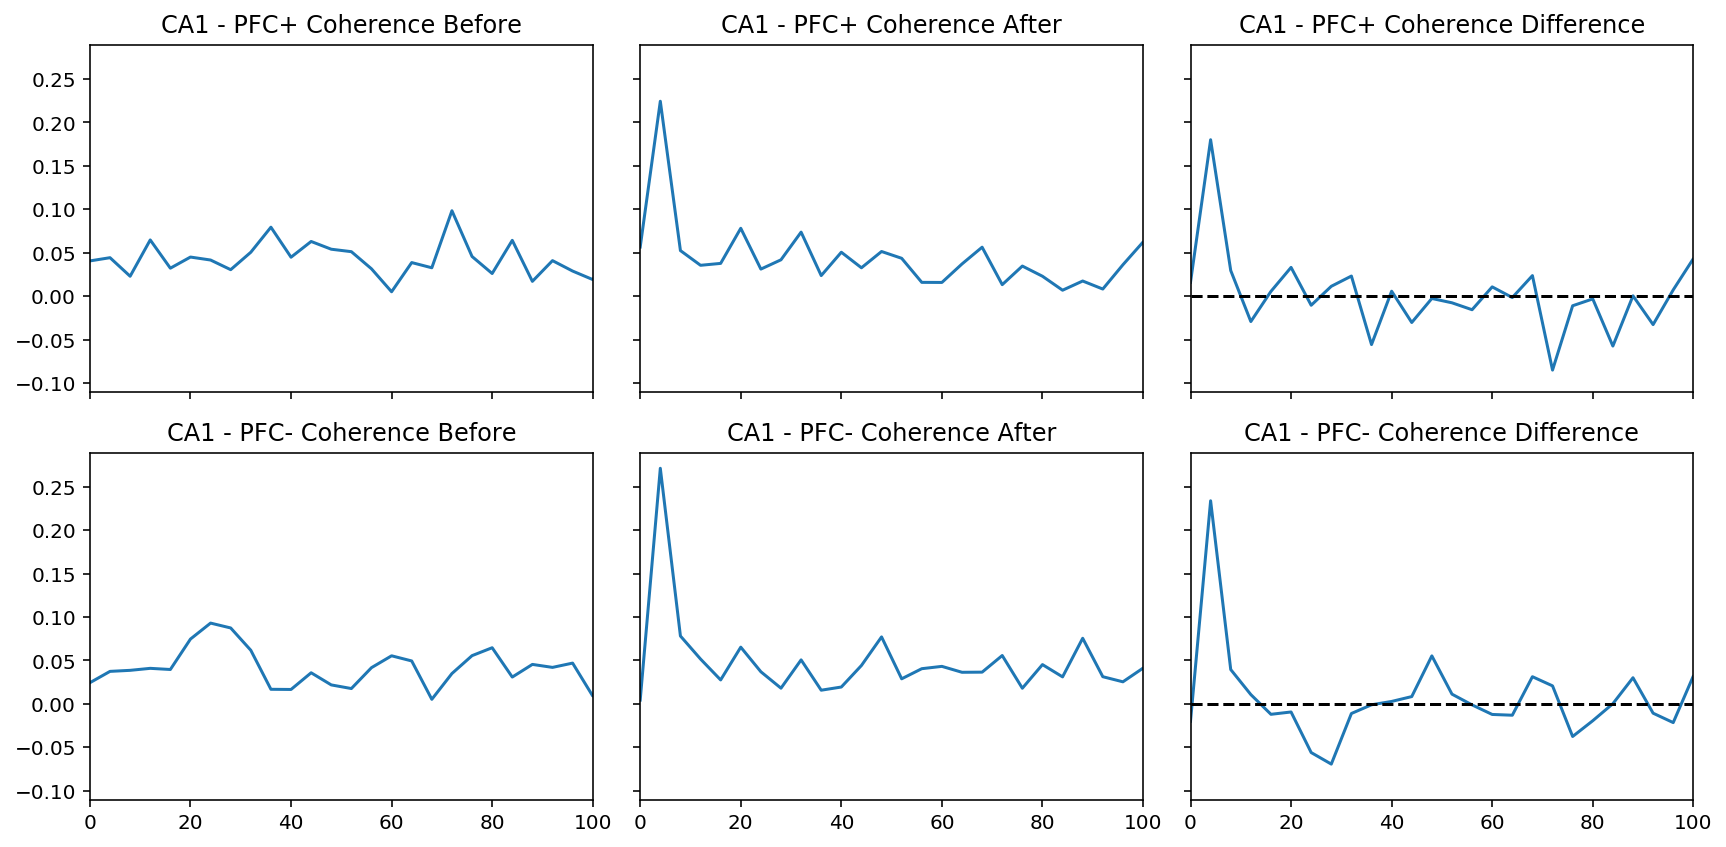

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

coherence_magnitude = adjusted_coherence_magnitude(
    spikes, sampling_frequency,
    time_window_duration=total_time / 2, time_halfbandwidth_product=1)
coherence_change = np.diff(coherence_magnitude, axis=0)

# Before
axes[0, 0].plot(c.frequencies, coherence_magnitude[0, :, 0, 1])
axes[0, 0].set_title('CA1 - PFC+ Coherence Before')
axes[1, 0].plot(c.frequencies, coherence_magnitude[0, :, 0, 2])
axes[1, 0].set_title('CA1 - PFC- Coherence Before')

# After
axes[0, 1].plot(c.frequencies, coherence_magnitude[1, :, 0, 1])
axes[0, 1].set_title('CA1 - PFC+ Coherence After')
axes[1, 1].plot(c.frequencies, coherence_magnitude[1, :, 0, 2])
axes[1, 1].set_title('CA1 - PFC- Coherence After')

# Difference
axes[0, 2].plot(c.frequencies, coherence_change[0, :, 0, 1])
axes[0, 2].set_title('CA1 - PFC+ Coherence Difference')
axes[0, 2].axhline(0, color='black', linestyle='--')
axes[1, 2].plot(c.frequencies, coherence_change[0, :, 0, 2])
axes[1, 2].set_title('CA1 - PFC- Coherence Difference')
axes[1, 2].axhline(0, color='black', linestyle='--')

plt.xlim((0, 100))
plt.tight_layout()